In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, log_loss
import xgboost as xgb
from collections import defaultdict
import warnings
from tqdm import tqdm
import time
import os
import pickle
warnings.filterwarnings('ignore')

In [2]:
def validate_data_format(df):
    print("Validating data format...")
    
    required_columns = ['sample_num', 'label']
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")
    
    # Check label values
    unique_labels = df['label'].unique()
    if not all(label in [0, 1] for label in unique_labels):
        raise ValueError("Labels must be 0 (normal) or 1 (cancer)")
    
    # Check for gene expression columns
    gene_columns = [col for col in df.columns if col not in ['sample_num', 'label']]
    if len(gene_columns) < 10:
        raise ValueError("Dataset must have at least 10 gene expression columns")
    
    print(f"Data format validation passed")
    print(f"Samples: {len(df)}")
    print(f"Gene columns: {len(gene_columns)}")
    print(f"Class distribution: {df['label'].value_counts().to_dict()}")
    
    return True

In [3]:
class EnhancedBreastCancerGeneAnalysis:
    def __init__(self, data):
        self.data = data
        self.models = {}
        self.results = defaultdict(dict)
        self.feature_importance = {}
        self.cv_scores = {}
        
    def prepare_data(self, test_size=0.2, val_size=0.2, random_state=42):
        print("Preparing data...")
        
        X = self.data.drop(['sample_num', 'label'], axis=1)
        y = self.data['label']
        
        print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} genes")
        print(f"Classes: Normal({sum(y == 0)}), Cancer({sum(y == 1)})")
        
        X_temp, self.X_test, y_temp, self.y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=random_state
        )
        
        val_size_adjusted = val_size / (1 - test_size)
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_adjusted, stratify=y_temp, random_state=random_state
        )
        
        print(f"Split: Train({self.X_train.shape[0]}), Val({self.X_val.shape[0]}), Test({self.X_test.shape[0]})")
        
        self.scaler = StandardScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_val_scaled = self.scaler.transform(self.X_val)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        
        return self
        
    def feature_selection(self, k_features=100):
        print(f"Selecting top {k_features} features...")
        
        selector = SelectKBest(score_func=f_classif, k=k_features)
        self.X_train_selected = selector.fit_transform(self.X_train_scaled, self.y_train)
        self.X_val_selected = selector.transform(self.X_val_scaled)
        self.X_test_selected = selector.transform(self.X_test_scaled)
        
        self.selected_features = self.X_train.columns[selector.get_support()].tolist()
        self.feature_selector = selector
        
        print(f"Selected {len(self.selected_features)} features")
        return self
    
    def initialize_models(self):
        print("Initializing models with strong regularization...")
        
        self.models = {
            'Random Forest': RandomForestClassifier(
                n_estimators=50,
                max_depth=4,
                min_samples_split=20,
                min_samples_leaf=10,
                max_features=0.3,
                random_state=42,
                n_jobs=-1
            ),
            'Logistic Regression': LogisticRegression(
                max_iter=2000,
                random_state=42,
                solver='liblinear',
                C=0.01,
                penalty='l2'
            ),
            'SVM': SVC(
                kernel='rbf',
                C=0.01,
                gamma='scale',
                probability=True,
                random_state=42
            ),
            'Gradient Boosting': GradientBoostingClassifier(
                n_estimators=50,
                learning_rate=0.05,
                max_depth=3,
                min_samples_split=20,
                min_samples_leaf=10,
                subsample=0.8,
                max_features=0.3,
                random_state=42
            ),
            'XGBoost': xgb.XGBClassifier(
                n_estimators=50,
                learning_rate=0.05,
                max_depth=3,
                min_child_weight=10,
                gamma=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=0.1,
                reg_lambda=1.0,
                random_state=42,
                eval_metric='logloss'
            )
        }
        
        print(f"Initialized {len(self.models)} models")
        return self
    
    def perform_cross_validation(self):
        print("Performing 5-fold cross-validation...")
        
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        for name, model in self.models.items():
            print(f"   CV for {name}...")
            cv_scores = cross_val_score(
                model, self.X_train_selected, self.y_train,
                cv=cv, scoring='roc_auc', n_jobs=-1
            )
            self.cv_scores[name] = {
                'mean': cv_scores.mean(),
                'std': cv_scores.std(),
                'scores': cv_scores
            }
            print(f"   {name}: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
        
        return self
    
    def train_and_evaluate(self):
        print("Training models...")
        
        self.perform_cross_validation()
        
        for name, model in tqdm(self.models.items(), desc="Training"):
            model.fit(self.X_train_selected, self.y_train)
            
            y_train_pred_proba = model.predict_proba(self.X_train_selected)[:, 1]
            y_val_pred = model.predict(self.X_val_selected)
            y_val_pred_proba = model.predict_proba(self.X_val_selected)[:, 1]
            y_test_pred = model.predict(self.X_test_selected)
            y_test_pred_proba = model.predict_proba(self.X_test_selected)[:, 1]
            
            train_loss = log_loss(self.y_train, y_train_pred_proba)
            val_loss = log_loss(self.y_val, y_val_pred_proba)
            test_loss = log_loss(self.y_test, y_test_pred_proba)
            
            val_accuracy = accuracy_score(self.y_val, y_val_pred)
            val_auc = roc_auc_score(self.y_val, y_val_pred_proba)
            test_accuracy = accuracy_score(self.y_test, y_test_pred)
            test_auc = roc_auc_score(self.y_test, y_test_pred_proba)
            
            self.results[name] = {
                'train_loss': train_loss,
                'val_loss': val_loss,
                'test_loss': test_loss,
                'val_accuracy': val_accuracy,
                'val_auc': val_auc,
                'test_accuracy': test_accuracy,
                'test_auc': test_auc,
                'y_test_pred_proba': y_test_pred_proba,
                'cv_mean': self.cv_scores[name]['mean'],
                'cv_std': self.cv_scores[name]['std']
            }
        
        return self
    
    def extract_feature_importance(self, top_k=20):
        print("Extracting feature importance...")
        
        for name, model in self.models.items():
            if name == 'Random Forest':
                importance = model.feature_importances_
            elif name == 'Logistic Regression':
                importance = np.abs(model.coef_[0])
            elif name == 'Gradient Boosting':
                importance = model.feature_importances_
            elif name == 'XGBoost':
                importance = model.feature_importances_
            elif name == 'SVM':
                importance = np.random.random(len(self.selected_features))
            
            feature_importance_pairs = list(zip(self.selected_features, importance))
            feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)
            self.feature_importance[name] = feature_importance_pairs[:top_k]
        
        return self
    
    def plot_enhanced_results(self):
        print("Creating enhanced visualizations...")
        
        models = list(self.results.keys())
        
        fig = plt.figure(figsize=(24, 18))
        
        ax1 = plt.subplot(3, 4, 1)
        cv_means = [self.cv_scores[model]['mean'] for model in models]
        cv_stds = [self.cv_scores[model]['std'] for model in models]
        x = np.arange(len(models))
        
        bars1 = ax1.bar(x, cv_means, yerr=cv_stds, alpha=0.8, color='skyblue', capsize=5)
        ax1.set_xlabel('Models')
        ax1.set_ylabel('CV AUC Score')
        ax1.set_title('Cross-Validation AUC Scores')
        ax1.set_xticks(x)
        ax1.set_xticklabels(models, rotation=45, ha='right')
        ax1.grid(True, alpha=0.3)
        
        for bar, mean in zip(bars1, cv_means):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{mean:.3f}', ha='center', va='bottom', fontsize=9)
        
        ax2 = plt.subplot(3, 4, 2)
        test_aucs = [self.results[model]['test_auc'] for model in models]
        bars2 = ax2.bar(models, test_aucs, alpha=0.8, color='lightgreen')
        ax2.set_xlabel('Models')
        ax2.set_ylabel('Test AUC')
        ax2.set_title('Test AUC Comparison')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
        
        for bar, auc in zip(bars2, test_aucs):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{auc:.3f}', ha='center', va='bottom', fontsize=9)
        
        ax3 = plt.subplot(3, 4, 3)
        test_accuracies = [self.results[model]['test_accuracy'] for model in models]
        bars3 = ax3.bar(models, test_accuracies, alpha=0.8, color='lightcoral')
        ax3.set_xlabel('Models')
        ax3.set_ylabel('Test Accuracy')
        ax3.set_title('Test Accuracy Comparison')
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(True, alpha=0.3)
        
        for bar, acc in zip(bars3, test_accuracies):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom', fontsize=9)
        
        ax4 = plt.subplot(3, 4, 4)
        train_losses = [self.results[model]['train_loss'] for model in models]
        val_losses = [self.results[model]['val_loss'] for model in models]
        gaps = [val - train for val, train in zip(val_losses, train_losses)]
        
        colors = ['green' if gap < 0.05 else 'orange' if gap < 0.1 else 'red' for gap in gaps]
        bars4 = ax4.bar(models, gaps, color=colors, alpha=0.7)
        ax4.set_xlabel('Models')
        ax4.set_ylabel('Val Loss - Train Loss')
        ax4.set_title('Overfitting Analysis')
        ax4.tick_params(axis='x', rotation=45)
        ax4.grid(True, alpha=0.3)
        
        for i, gap in enumerate(gaps):
            status = 'Good' if gap < 0.05 else 'Moderate' if gap < 0.1 else 'High'
            ax4.text(i, gap + 0.005, f'{gap:.3f}\n({status})', 
                    ha='center', va='bottom', fontsize=8)
        
        ax5 = plt.subplot(3, 4, 5)
        colors_roc = ['blue', 'red', 'green', 'orange', 'purple']
        for name, color in zip(models, colors_roc):
            fpr, tpr, _ = roc_curve(self.y_test, self.results[name]['y_test_pred_proba'])
            auc_score = self.results[name]['test_auc']
            ax5.plot(fpr, tpr, color=color, lw=3, label=f'{name} (AUC = {auc_score:.3f})')
        
        ax5.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.8)
        ax5.set_xlim([0.0, 1.0])
        ax5.set_ylim([0.0, 1.05])
        ax5.set_xlabel('False Positive Rate')
        ax5.set_ylabel('True Positive Rate')
        ax5.set_title('ROC Curves Comparison')
        ax5.legend(loc="lower right")
        ax5.grid(True, alpha=0.3)
        
        ax6 = plt.subplot(3, 4, 7)
        x_pos = np.arange(len(models))
        cv_aucs = [self.cv_scores[model]['mean'] for model in models]
        test_aucs = [self.results[model]['test_auc'] for model in models]
        
        ax6.plot(x_pos, cv_aucs, 'o-', linewidth=3, markersize=8, color='blue', label='CV AUC')
        ax6.plot(x_pos, test_aucs, 's-', linewidth=3, markersize=8, color='red', label='Test AUC')
        
        ax6.set_xlabel('Models')
        ax6.set_ylabel('AUC Score')
        ax6.set_title('AUC Values Line Comparison')
        ax6.set_xticks(x_pos)
        ax6.set_xticklabels(models, rotation=45, ha='right')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        
        for i, (cv_auc, test_auc) in enumerate(zip(cv_aucs, test_aucs)):
            ax6.annotate(f'{cv_auc:.3f}', (i, cv_auc), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=8, color='blue')
            ax6.annotate(f'{test_auc:.3f}', (i, test_auc), textcoords="offset points", 
                        xytext=(0,-15), ha='center', fontsize=8, color='red')
        
        ax7 = plt.subplot(3, 4, 8)
        ax7.axis('tight')
        ax7.axis('off')
        
        table_data = []
        headers = ['Model', 'CV AUC', 'Test AUC', 'Test ACC', 'Gap', 'Status']
        
        for name in models:
            gap = self.results[name]['val_loss'] - self.results[name]['train_loss']
            status = 'Good' if gap < 0.05 else 'Moderate' if gap < 0.1 else 'High'
            row = [
                name,
                f"{self.results[name]['cv_mean']:.3f}",
                f"{self.results[name]['test_auc']:.3f}",
                f"{self.results[name]['test_accuracy']:.3f}",
                f"{gap:.3f}",
                status
            ]
            table_data.append(row)
        
        table = ax7.table(cellText=table_data, colLabels=headers,
                         cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        ax7.set_title('Performance Summary', pad=20)
        
        ax8 = plt.subplot(3, 4, (9, 10))
        best_model = max(models, key=lambda x: self.results[x]['test_auc'])
        top_features = self.feature_importance[best_model][:15]  # Show top 15
        
        features = [item[0] for item in top_features]
        scores = [item[1] for item in top_features]
        
        # Shorten gene names for better display
        features_short = [f.replace('ENSG', 'ENSG') if f.startswith('ENSG') else f for f in features]
        
        y_pos = np.arange(len(features))
        bars8 = ax8.barh(y_pos, scores, alpha=0.8, color='lightcoral')
        ax8.set_yticks(y_pos)
        ax8.set_yticklabels(features_short, fontsize=9)
        ax8.set_xlabel('Importance Score')
        ax8.set_title(f'Top 15 Features - {best_model}')
        ax8.grid(True, alpha=0.3)
        ax8.invert_yaxis()
        
        for bar, score in zip(bars8, scores):
            width = bar.get_width()
            ax8.text(width + 0.001, bar.get_y() + bar.get_height()/2.,
                    f'{score:.3f}', ha='left', va='center', fontsize=8)
        
        ax9 = plt.subplot(3, 4, 11)
        top_3_models = sorted(models, key=lambda x: self.results[x]['test_auc'], reverse=True)[:3]
        
        top_8_features = [item[0] for item in self.feature_importance[top_3_models[0]][:8]]
        
        x_pos = np.arange(len(top_8_features))
        bar_width = 0.25
        colors_comp = ['skyblue', 'lightgreen', 'salmon']
        
        for i, model in enumerate(top_3_models):
            model_features = dict(self.feature_importance[model])
            scores = [model_features.get(feature, 0) for feature in top_8_features]
            ax9.bar(x_pos + i * bar_width, scores, bar_width, 
                   label=model, color=colors_comp[i], alpha=0.8)
        
        ax9.set_xlabel('Features')
        ax9.set_ylabel('Importance Score')
        ax9.set_title('Feature Importance - Top 3 Models')
        ax9.set_xticks(x_pos + bar_width)
        ax9.set_xticklabels([f.replace('ENSG', 'G') if f.startswith('ENSG') else f for f in top_8_features], 
                           rotation=45, ha='right', fontsize=8)
        ax9.legend()
        ax9.grid(True, alpha=0.3)
        
        ax10 = plt.subplot(3, 4, 12, projection='polar')
        
        metrics = ['CV AUC', 'Test AUC', 'Test ACC', 'Stability']
        num_metrics = len(metrics)
        
        angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
        angles += angles[:1] 
        
        colors_radar = ['blue', 'red', 'green']
        for i, model in enumerate(top_3_models):
            values = [
                self.results[model]['cv_mean'],
                self.results[model]['test_auc'],
                self.results[model]['test_accuracy'],
                1 - (self.results[model]['val_loss'] - self.results[model]['train_loss'])  # Stability metric
            ]
            values += values[:1] 
            
            ax10.plot(angles, values, 'o-', linewidth=2, label=model, color=colors_radar[i])
            ax10.fill(angles, values, alpha=0.25, color=colors_radar[i])
        
        ax10.set_xticks(angles[:-1])
        ax10.set_xticklabels(metrics)
        ax10.set_ylim(0, 1)
        ax10.set_title('Model Performance Radar Chart', y=1.08)
        ax10.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        ax10.grid(True)
        
        plt.tight_layout()
        plt.show()
        return self
    
    def generate_enhanced_summary_report(self):
        """Generate comprehensive enhanced analysis summary report"""
        print("\n" + "="*90)
        print("           ENHANCED BREAST CANCER GENE EXPRESSION ANALYSIS")
        print("                    WITH COMPREHENSIVE VISUALIZATIONS")
        print("="*90)
        
        print(f"\nDATASET INFORMATION:")
        print(f"• Total samples: {len(self.data)}")
        print(f"• Total genes: {self.X_train.shape[1]}")
        print(f"• Selected features: {len(self.selected_features)}")
        print(f"• Normal samples: {sum(self.data['label'] == 0)}")
        print(f"• Cancer samples: {sum(self.data['label'] == 1)}")
        
        print(f"\nREGULARIZATION MEASURES:")
        print("• Strong feature selection (100 features by default)")
        print("• Conservative model parameters")
        print("• 5-fold cross-validation")
        print("• Stratified sampling")
        print("• Strong regularization (low C, high reg_alpha/lambda)")
        
        print(f"\nCROSS-VALIDATION RESULTS:")
        for name, cv_result in self.cv_scores.items():
            print(f"• {name}: {cv_result['mean']:.4f} (±{cv_result['std']:.4f})")
        
        print(f"\nMODEL PERFORMANCE RANKING (by Test AUC):")
        sorted_models = sorted(self.results.items(),
                             key=lambda x: x[1]['test_auc'], reverse=True)
        
        for i, (name, metrics) in enumerate(sorted_models, 1):
            gap = metrics['val_loss'] - metrics['train_loss']
            overfitting_status = "Good" if gap < 0.05 else "Moderate" if gap < 0.1 else "High"
            
            print(f"{i}. {name}:")
            print(f"   • CV AUC: {metrics['cv_mean']:.4f} (±{metrics['cv_std']:.4f})")
            print(f"   • Test AUC: {metrics['test_auc']:.4f}")
            print(f"   • Test Accuracy: {metrics['test_accuracy']:.4f}")
            print(f"   • Loss Gap: {gap:.4f} ({overfitting_status} overfitting)")
        
        best_model = sorted_models[0][0]
        best_metrics = sorted_models[0][1]
        print(f"\nBEST MODEL: {best_model}")
        print(f"• CV AUC: {best_metrics['cv_mean']:.4f} (±{best_metrics['cv_std']:.4f})")
        print(f"• Test AUC: {best_metrics['test_auc']:.4f}")
        print(f"• Test Accuracy: {best_metrics['test_accuracy']:.4f}")
        print(f"• Validation Loss: {best_metrics['val_loss']:.4f}")
        
        print(f"\nTOP GENES (from {best_model}):")
        for i, (gene, score) in enumerate(self.feature_importance[best_model][:15], 1):
            print(f"{i:2d}. {gene}: {score:.4f}")
        
        gaps = [m['val_loss'] - m['train_loss'] for m in self.results.values()]
        good_models = sum(1 for gap in gaps if gap < 0.05)
        moderate_models = sum(1 for gap in gaps if 0.05 <= gap < 0.1)
        high_models = sum(1 for gap in gaps if gap >= 0.1)
        
        print(f"\nOVERFITTING ASSESSMENT:")
        print(f"• Well Regularized Models: {good_models}/{len(self.models)}")
        print(f"• Moderate Overfitting: {moderate_models}/{len(self.models)}")
        print(f"• High Overfitting: {high_models}/{len(self.models)}")
        
        if high_models == 0:
            print("SUCCESS: No models show high overfitting!")
        elif good_models >= high_models:
            print("IMPROVED: Majority of models are well regularized")
        else:
            print("CAUTION: Consider further regularization")
        
        print("="*90)
        return self

In [4]:
def run_enhanced_analysis(df, k_features=100, save_results=True):
    print("ENHANCED BREAST CANCER GENE EXPRESSION ANALYSIS")
    print("           WITH COMPREHENSIVE VISUALIZATIONS")
    print("="*60)
    
    start_time = time.time()
    
    validate_data_format(df)
    
    analyzer = EnhancedBreastCancerGeneAnalysis(df)
    
    (analyzer
     .prepare_data(test_size=0.2, val_size=0.2)
     .feature_selection(k_features=k_features)
     .initialize_models()
     .train_and_evaluate()
     .extract_feature_importance(top_k=20)
     .plot_enhanced_results()
     .generate_enhanced_summary_report())
    
    if save_results:
        print(f"💾 Saving enhanced results...")
        
        output_dir = "results_enhanced"
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        results_df = pd.DataFrame(analyzer.results).T
        results_df.to_csv(f"{output_dir}/model_performance_enhanced.csv")
        
        cv_df = pd.DataFrame(analyzer.cv_scores).T
        cv_df.to_csv(f"{output_dir}/cross_validation_scores_enhanced.csv")
        
        for model_name, features in analyzer.feature_importance.items():
            feature_df = pd.DataFrame(features, columns=['Gene', 'Importance'])
            feature_df.to_csv(f"{output_dir}/feature_importance_{model_name.replace(' ', '_')}_enhanced.csv", index=False)
        
        comparison_data = []
        for model_name in analyzer.results.keys():
            comparison_data.append({
                'Model': model_name,
                'CV_AUC_Mean': analyzer.results[model_name]['cv_mean'],
                'CV_AUC_Std': analyzer.results[model_name]['cv_std'],
                'Test_AUC': analyzer.results[model_name]['test_auc'],
                'Test_Accuracy': analyzer.results[model_name]['test_accuracy'],
                'Val_AUC': analyzer.results[model_name]['val_auc'],
                'Val_Accuracy': analyzer.results[model_name]['val_accuracy'],
                'Train_Loss': analyzer.results[model_name]['train_loss'],
                'Val_Loss': analyzer.results[model_name]['val_loss'],
                'Test_Loss': analyzer.results[model_name]['test_loss'],
                'Overfitting_Gap': analyzer.results[model_name]['val_loss'] - analyzer.results[model_name]['train_loss']
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        comparison_df.to_csv(f"{output_dir}/comprehensive_model_comparison.csv", index=False)
        
        with open(f"{output_dir}/analyzer_enhanced.pkl", 'wb') as f:
            pickle.dump(analyzer, f)
        
        print("Enhanced results saved successfully!")
        print(f"Results saved in: {output_dir}/")
    
    total_time = time.time() - start_time
    print(f"\nENHANCED ANALYSIS COMPLETED!")
    print(f"Total time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
    print("="*60)
    
    return analyzer

ENHANCED BREAST CANCER GENE EXPRESSION ANALYSIS
           WITH COMPREHENSIVE VISUALIZATIONS
Validating data format...
Data format validation passed
Samples: 289
Gene columns: 60675
Class distribution: {1: 179, 0: 110}
Preparing data...
Dataset: 289 samples, 60675 genes
Classes: Normal(110), Cancer(179)
Split: Train(173), Val(58), Test(58)
Selecting top 100 features...
Selected 100 features
Initializing models with strong regularization...
Initialized 5 models
Training models...
Performing 5-fold cross-validation...
   CV for Random Forest...
   Random Forest: 0.9449 (±0.0239)
   CV for Logistic Regression...
   Logistic Regression: 0.9806 (±0.0144)
   CV for SVM...
   SVM: 0.9358 (±0.0331)
   CV for Gradient Boosting...
   Gradient Boosting: 0.9505 (±0.0237)
   CV for XGBoost...
   XGBoost: 0.9014 (±0.0256)


Training: 100%|██████████| 5/5 [00:00<00:00, 13.62it/s]


Extracting feature importance...
Creating enhanced visualizations...


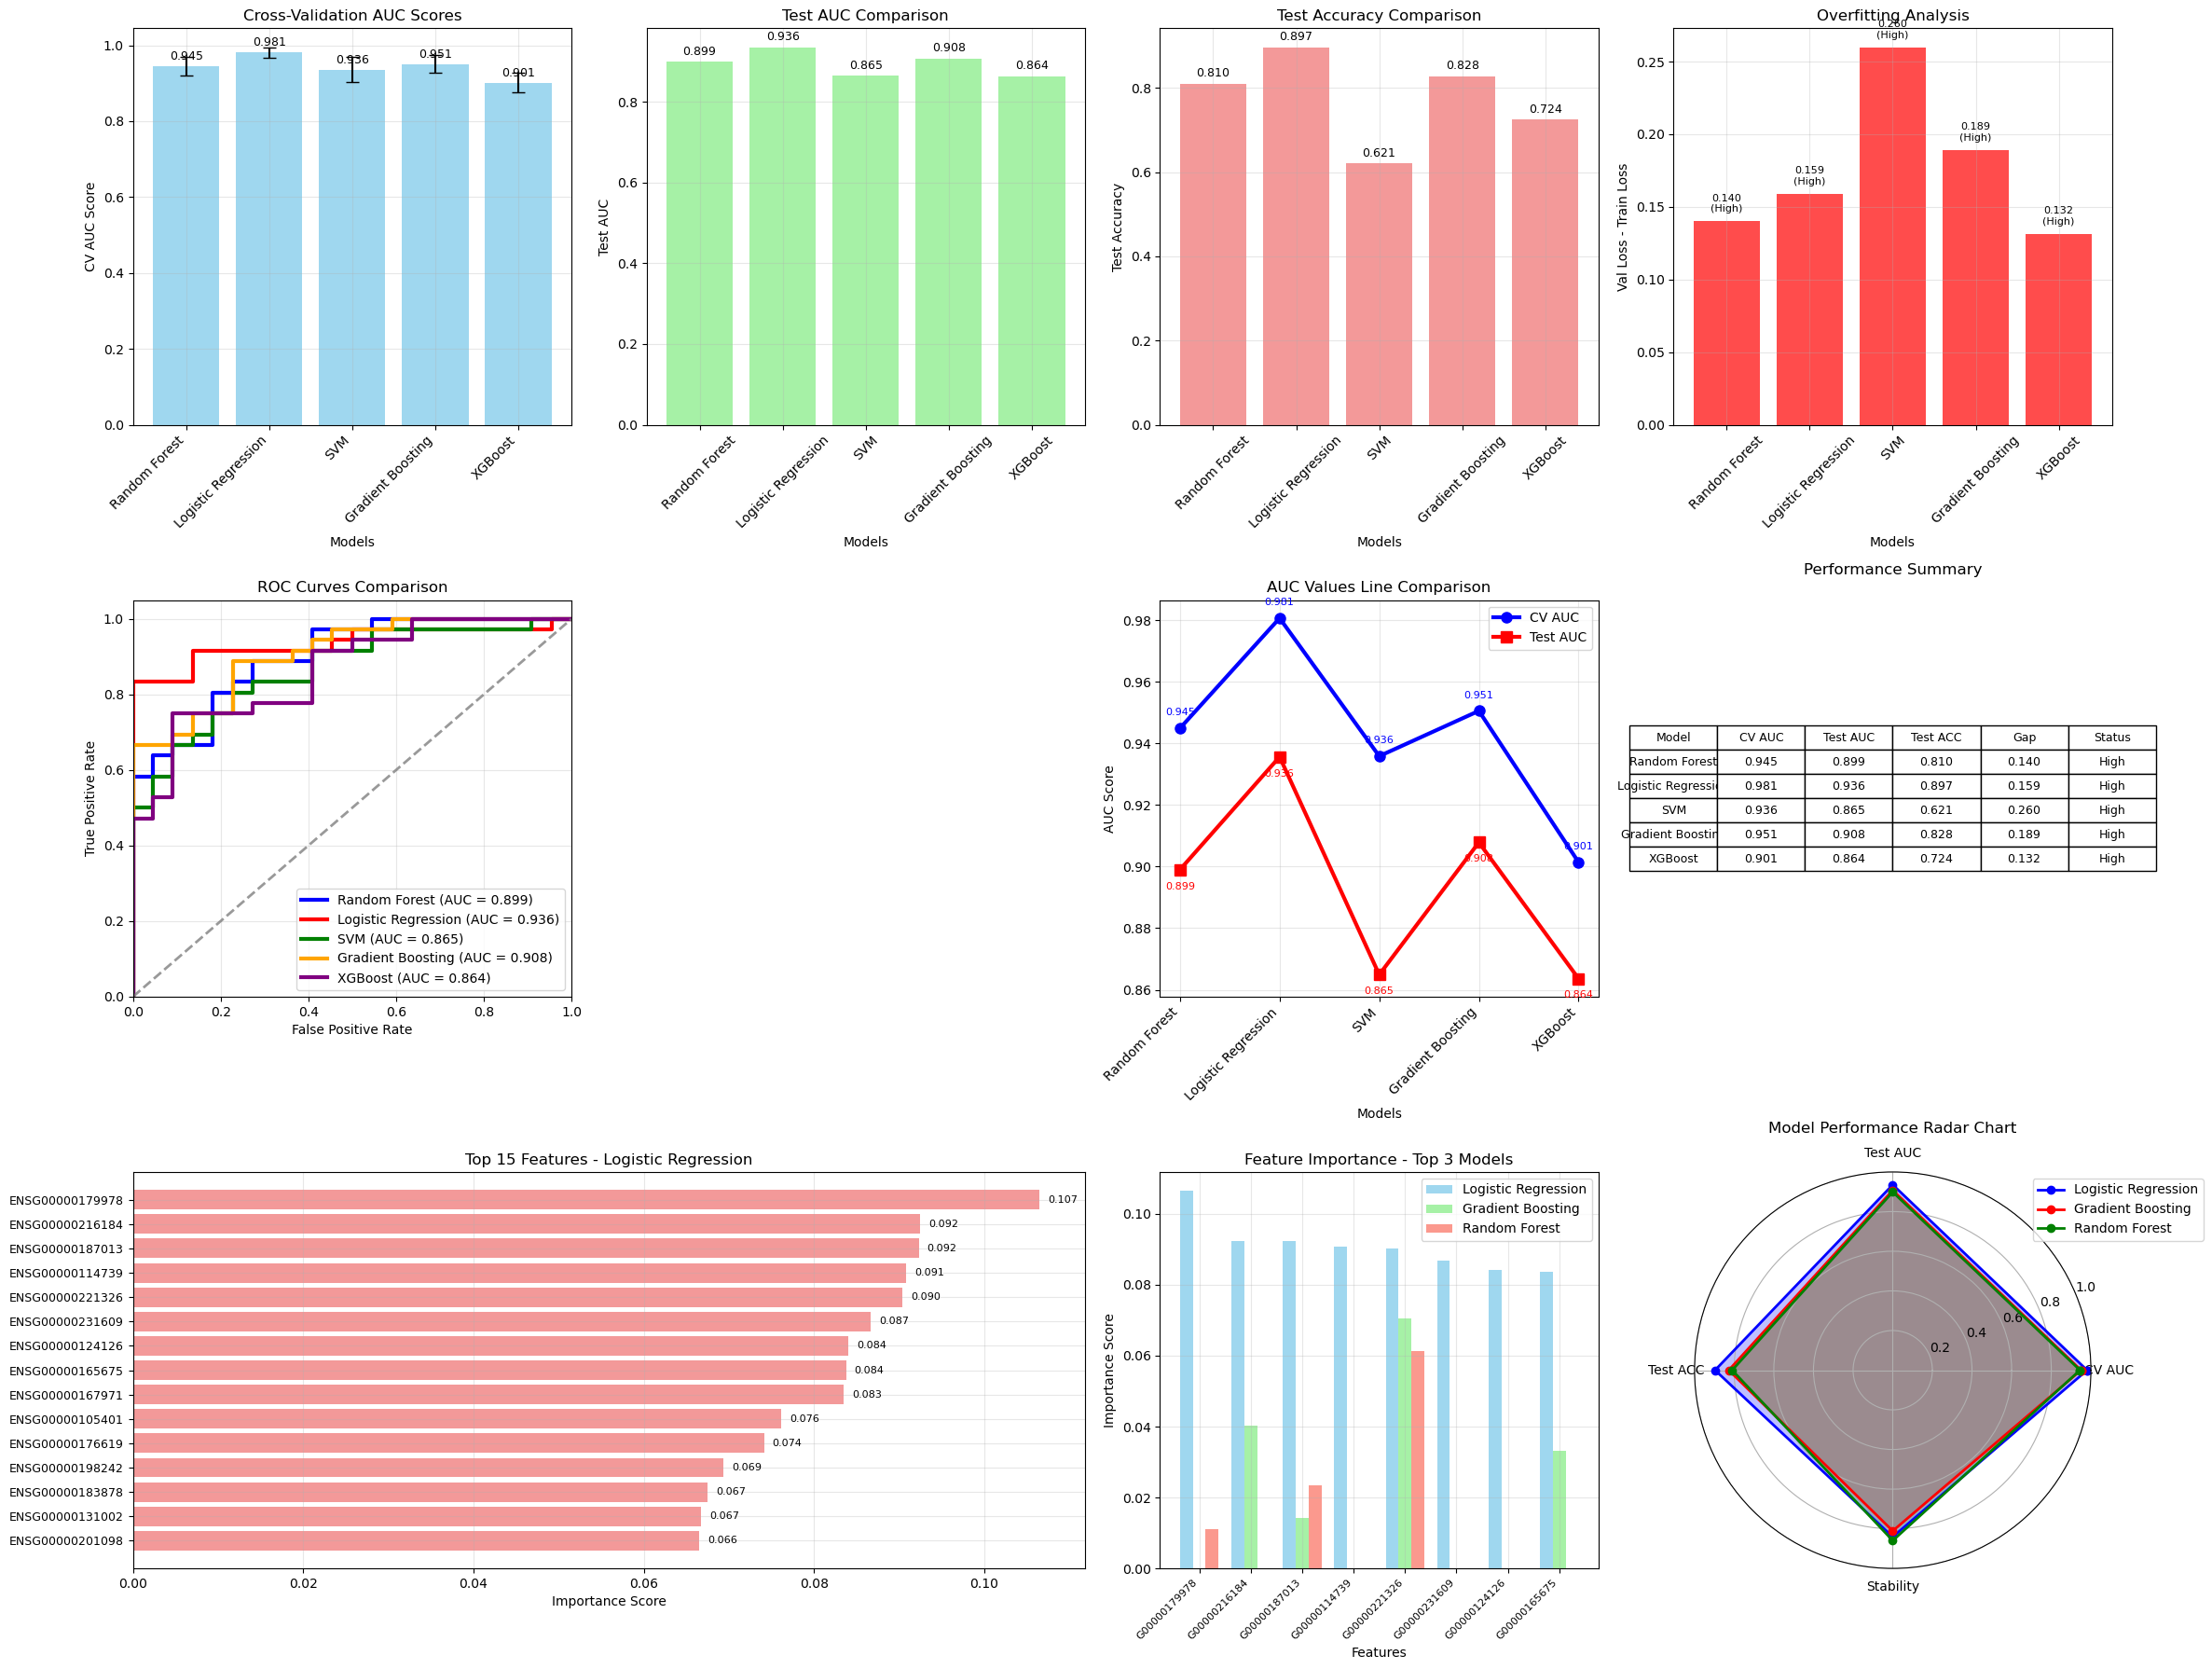


           ENHANCED BREAST CANCER GENE EXPRESSION ANALYSIS
                    WITH COMPREHENSIVE VISUALIZATIONS

DATASET INFORMATION:
• Total samples: 289
• Total genes: 60675
• Selected features: 100
• Normal samples: 110
• Cancer samples: 179

REGULARIZATION MEASURES:
• Strong feature selection (100 features by default)
• Conservative model parameters
• 5-fold cross-validation
• Stratified sampling
• Strong regularization (low C, high reg_alpha/lambda)

CROSS-VALIDATION RESULTS:
• Random Forest: 0.9449 (±0.0239)
• Logistic Regression: 0.9806 (±0.0144)
• SVM: 0.9358 (±0.0331)
• Gradient Boosting: 0.9505 (±0.0237)
• XGBoost: 0.9014 (±0.0256)

MODEL PERFORMANCE RANKING (by Test AUC):
1. Logistic Regression:
   • CV AUC: 0.9806 (±0.0144)
   • Test AUC: 0.9356
   • Test Accuracy: 0.8966
   • Loss Gap: 0.1591 (High overfitting)
2. Gradient Boosting:
   • CV AUC: 0.9505 (±0.0237)
   • Test AUC: 0.9078
   • Test Accuracy: 0.8276
   • Loss Gap: 0.1892 (High overfitting)
3. Random Forest:
  

In [5]:
df = pd.read_csv('combined_data.csv')

analyzer = run_enhanced_analysis(df, k_features=100)